# External Integration

## General

[Nino-hist](https://nino-hist.site) is a systematic tool based on [boost-histogram](https://boost-histogram.readthedocs.io/en/latest). The HEP analysis is a complicated process and relies on many other [(Sckit-HEP) tools](https://scikit-hep.org/). Thus, it's intuitive for [Nino-hist](https://nino-hist.site) to support the integration of these external packages and modules. In this part, we will demonstrate how [Nino-hist](https://nino-hist.site) works and its interaction with other [(Sckit-HEP) tools](https://scikit-hep.org/).

A brief workflow of HEP analysis is as below:

![](https://tva1.sinaimg.cn/large/00831rSTly1gd40ndja44j30lk058q3d.jpg)

Initialize a `Hist` instance like this and fill. We are going to see some new features of `Hist`.

## Histogramming

[Nino-hist](https://nino-hist.site) acts as the histogramming part, i.e., "Data" to "Histogram", in HEP analysis workflow. It is based on [boost-histogram](https://boost-histogram.readthedocs.io/en/latest), meaning that you can do whatever you like in [boost-histogram](https://boost-histogram.readthedocs.io/en/latest) with histograms of [Nino-hist](https://nino-hist.site). Let's see some examples.

First, we will re-use the 2D-density histogram example of [boost-histogram](https://boost-histogram.readthedocs.io/en/latest).

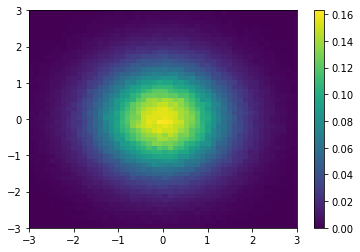

In [3]:
import hist
import numpy as np
import matplotlib.pyplot as plt

# Make a 2D histogram
hist = hist.Hist(hist.axis.Regular(50, -3, 3, name='x'), hist.axis.Regular(50, -3, 3, name='y'))

# Fill with Gaussian random values
hist.fill(np.random.normal(size=1_000_000), np.random.normal(size=1_000_000))

# Compute the areas of each bin
areas = np.prod(hist.axes.widths, axis=0)

# Compute the density
density = hist.view() / hist.sum() / areas

# Get the edges
X, Y = hist.axes.edges

# Make the plot
fig, ax = plt.subplots()
mesh = ax.pcolormesh(X.T, Y.T, density.T)
fig.colorbar(mesh)
plt.show()

Nice! This is good, because this means that you can migrate your [boost-histogram](https://boost-histogram.readthedocs.io/en/latest) codes to [Nino-hist](https://nino-hist.site) directly. 

## iminuit Integration

[iminuit](https://iminuit.readthedocs.io/en/latest/index.html) is most commonly used for likelihood fits of models to data, and to get model parameter error estimates from likelihood profile analysis. It's a numerical minimizer and error calculator. You provide it an analytical function, which accepts one or several parameters, and an initial guess of the parameter values. It will then find a local minimum of this function starting from the initial guess. In that regard, [iminuit](https://iminuit.readthedocs.io/en/latest/index.html) is similar to other minimizers, like those in `scipy.optimize`.

Let's use an example to see how can [iminuit](https://iminuit.readthedocs.io/en/latest/index.html) fits the data in [Nino-hist](https://nino-hist.site).

Hist(Regular(20, 0, 10, underflow=False, overflow=False, metadata={'name': 'iminuit', 'title': None}), storage=Double()) # Sum: 833.0189448868877

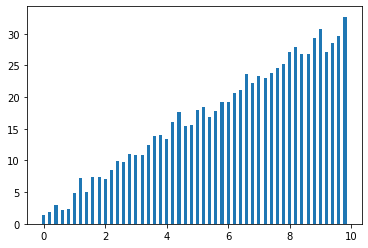

In [5]:
import hist
import numpy as np
import matplotlib.pyplot as plt

k = 3.
b = 2.
data_x = np.arange(0, 10, .2)
offset = np.random.normal(size=50)
data_y = k * data_x + b + offset

plt.bar(data_x, data_y, width=0.1)

h = hist.Hist(
    hist.axis.Regular(20, 0, 10, name='iminuit', underflow=False, overflow=False)
)

h.fill(data_x, weight=data_y)

By this way, we create and fill a histogram with the linear distribution, i.e., the weight of each bin is the multiple of its index. Of course you can also use a histogram loading by serialization. Back to the point, it's a linear distribution, and we want to use a fitter to get its slope `k` and intercept `b`.

First, we need to access the data (the weight of histogram) and define the error func to be minimized.

In [6]:
y, x = h.to_numpy()

def least_squares_np(par):  # par is a numpy array here 
    mu = np.polyval(par, data_x)  # for par = (a, b) this is a line
    yvar = 0.01
    return np.sum((data_y - mu) ** 2 / yvar)

Then, we will initialized the parameters in an array (two elements in this linear case), the step size, and the error definition (`errordef = 0.5` for negative log-likelihood functions, `errordef = 1` for least-squares functions). You are able to see the minuit initial states use `get_param_states()`.

In [7]:
from iminuit import Minuit

m = Minuit.from_array_func(least_squares_np, (5, 5), error=(0.1, 0.1), errordef=1, name=('k', 'b'))
m.get_param_states()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | k    |   5.00    |   0.10    |            |            |         |         |       |
| 1 | b    |   5.00    |   0.10    |            |            |         |         |       |
------------------------------------------------------------------------------------------

And it's time for fitting! It's pretty handy in [iminuit](https://iminuit.readthedocs.io/en/latest/index.html), just `m.migrad()` is ok. Of course you can use more specific methods like fixed, limits, fast fitting methods, etc. This is just the simplest way to fit.

In [8]:
m.migrad()
# m.get_param_states()

------------------------------------------------------------------
| FCN = 5356                    |      Ncalls=34 (34 total)      |
| EDM = 4.18E-20 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | k    |   3.028   |   0.005   |            |            |         |         |       |
| 1 | b    |   1.824   |   0.028   |            |            |         |         |       |
------------------------------------------------------------------------------------------

Nice! It's almost true! Next, we want to visualized our fitting (the correlationship of two params and the params' scopes).

We can analysis the correlationship of the params to eliminate some of them.

In [9]:
m.matrix(correlation=True)

-----------------
|   |    k    b |
-----------------
| k |  1.0 -0.9 |
| b | -0.9  1.0 |
-----------------

We can also use contour to represent it.

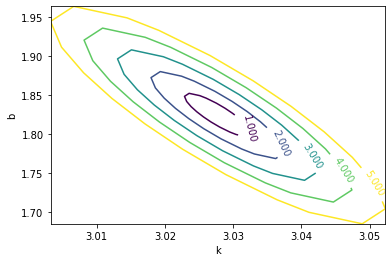

In [10]:
m.draw_mncontour('k','b', nsigma=5);  # draw five contours from sigma=1 to 5
# m.draw_contour('k','b');

We can also view the scope of those params.

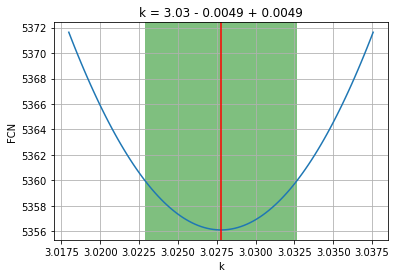

In [11]:
m.draw_profile('k');
# m.draw_profile('b');

To sum up, [Nino-hist](https://nino-hist.site) allow user to fit data by interacting with [iminuit](https://iminuit.readthedocs.io/en/latest/index.html). Sepcifically, you need to convert your histogram to numpy format, and then [iminuit](https://iminuit.readthedocs.io/en/latest/index.html) will deal with that. With numpy arrays as the media, it's flexible. You can do whatever you want in [iminuit](https://iminuit.readthedocs.io/en/latest/index.html) with the histograms of [Nino-hist](https://nino-hist.site). This is valuable for "Histogram" to "Analysis" in HEP analyse workflow!

## mplhep Integration

Although we can use Matplotlib to visualize our histograms, it should be a better way to do the same thing in a, umm... [(Sckit-HEP)](https://scikit-hep.org/) manner. [mplhep](https://github.com/scikit-hep/mplhep) is a set of helpers for matplotlib to more easily produce plots typically needed in HEP as well as style them in way that's compatible with current collaboration requirements (ROOT).

Let's use an example to see how [mplhep](https://github.com/scikit-hep/mplhep) visualizes the histograms in [Nino-hist](https://nino-hist.site).

First, create 1-D and 2-D histograms.

In [12]:
import hist
import numpy as np
import matplotlib.pyplot as plt

data_x = np.random.normal(loc=0., scale=1., size=1_000_000)
data_y = np.random.normal(loc=0., scale=1., size=1_000_000)

h_1d = hist.Hist(
    hist.axis.Regular(500, -3, 3, name='x_1d', underflow=False, overflow=False)
)

h_1d.fill(data_x)

h_2d = hist.Hist(
    hist.axis.Regular(500, -3, 3, name='x_2d', underflow=False, overflow=False),
    hist.axis.Regular(500, -3, 3, name='y_2d', underflow=False, overflow=False)
)

h_2d.fill(data_x, data_y)

Hist(
  Regular(500, -3, 3, underflow=False, overflow=False, metadata={'name': 'x-2d', 'title': None}),
  Regular(500, -3, 3, underflow=False, overflow=False, metadata={'name': 'y-2d', 'title': None}),
  storage=Double()) # Sum: 994598.0

Then, we can plot our histogram. (*[mplhep](https://github.com/scikit-hep/mplhep) is in its infancy, with a few very single features, but I'm sure there will be better interfaces later.*)

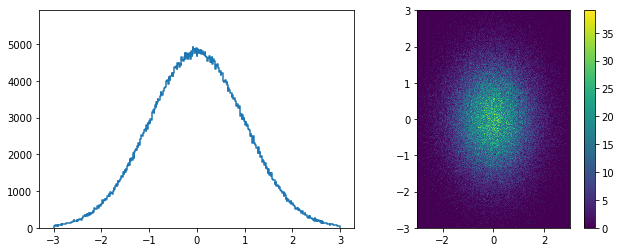

In [13]:
import mplhep

# plt.style.use(mplhep.style.LHCb)
plt.subplot(121)
w, xbins = h_1d.to_numpy()
mplhep.histplot(w.T, xbins)

plt.subplot(122)
w, xbins, ybins = h_2d.to_numpy()
mplhep.hist2dplot(w.T, xbins, ybins)

To sum up, [Nino-hist](https://nino-hist.site) allow user to visualize data by interacting with [mplhep](https://github.com/scikit-hep/mplhep). Sepcifically, you need to convert your histogram to numpy format, and then [mplhep](https://github.com/scikit-hep/mplhep) will deal with that. With numpy arrays as the media, it's flexible. You can do whatever you want in [mplhep](https://github.com/scikit-hep/mplhep) with the histograms of [Nino-hist](https://nino-hist.site). This is valuable for "Analysis" to "Visualization" in HEP analyse workflow!